In [ ]:
import os
import numpy as np
import librosa

def calculate_duration(file_path):
    y, sr = librosa.load(file_path, sr=None)
    duration = librosa.get_duration(y=y, sr=sr)
    return duration, sr

def pad_signal(signal, max_len):
    padding_length = max_len - len(signal)
    if padding_length > 0:
        signal = np.pad(signal, (0, padding_length), 'constant')
    return signal

def segment_signal(signal, sr, segment_duration=2):
    segment_length = segment_duration * sr  # Segment length in samples
    segments = []

    for start in range(0, len(signal), segment_length):
        end = start + segment_length
        segment = signal[start:end]
        if len(segment) == segment_length:  # Ensure segment is full-length
            segments.append(segment)

    return np.array(segments)

def find_matching_files(speech_folder, breath_folder):
    matched_files = []
    for root, dirs, files in os.walk(speech_folder):
        for file in files:
            if file.endswith('.wav'):
                # Replace "channel1" in the speech filename with "channel3" for the breath signal
                speech_file_path = os.path.join(root, file)
                breath_file_name = file.replace('channel1', 'channel3')
                breath_file_path = os.path.join(breath_folder, breath_file_name)

                if os.path.exists(breath_file_path):
                    matched_files.append((speech_file_path, breath_file_path))
                else:
                    print(f"No matching breath file found for {speech_file_path}")

    return matched_files

def process_matched_files(matched_files, segment_duration=2):
    max_duration = 0
    sample_rate = None

    # First pass: Find the maximum duration among matched files
    for speech_file, breath_file in matched_files:
        duration, sr = calculate_duration(speech_file)
        if duration > max_duration:
            max_duration = duration
        if sample_rate is None:
            sample_rate = sr

    max_len_samples = int(max_duration * sample_rate)

    # Second pass: Pad and segment the audio and breath signals
    x_train = []
    y_train = []
    for speech_file, breath_file in matched_files:
        try:
            # Load and pad speech signal
            y_speech, sr_speech = librosa.load(speech_file, sr=sample_rate)
            y_speech_padded = pad_signal(y_speech, max_len_samples)

            # Load and pad breath signal
            y_breath, sr_breath = librosa.load(breath_file, sr=sample_rate)
            y_breath_padded = pad_signal(y_breath, max_len_samples)

            # Segment the padded signals
            speech_segments = segment_signal(y_speech_padded, sr_speech, segment_duration)
            breath_segments = segment_signal(y_breath_padded, sr_breath, segment_duration)

            x_train.extend(speech_segments)
            y_train.extend(breath_segments)
        except Exception as e:
            print(f"Error processing files {speech_file} and {breath_file}: {e}")

    x_train = np.array(x_train)
    y_train = np.array(y_train)

    return max_duration, sample_rate, x_train, y_train

# Example usage
speech_folder = '/content/sample_data/Speech Train'
breath_folder = '/content/sample_data/Breath Train'

matched_files = find_matching_files(speech_folder, breath_folder)

if matched_files:
    max_duration, sample_rate, x_train, y_train = process_matched_files(matched_files)
    print(f'Maximum duration of WAV files: {max_duration} seconds')
    print(f'Sample rate of the audio files: {sample_rate}')
    print(f'Shape of x_train: {x_train.shape}')
    print(f'Shape of y_train: {y_train.shape}')
else:
    print("No matching files found between speech and breath folders.")


Maximum duration of WAV files: 120.29945 seconds
Sample rate of the audio files: 20000
Shape of x_train: (1440, 40000)
Shape of y_train: (1440, 40000)


In [ ]:
import tensorflow as tf

def create_model(input_shape):
    model = tf.keras.Sequential()

    # First Conv1D Layer
    model.add(tf.keras.layers.Conv1D(input_shape=input_shape, filters=64, kernel_size=10, strides=1, activation='relu', padding='same'))
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.MaxPool1D(pool_size=2))  # Reduced pool size

    # Second Conv1D Layer
    model.add(tf.keras.layers.Conv1D(filters=128, kernel_size=8, strides=1, activation='relu', padding='same'))
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.MaxPool1D(pool_size=2))  # Reduced pool size

    # Third Conv1D Layer
    model.add(tf.keras.layers.Conv1D(filters=256, kernel_size=6, strides=1, activation='relu', padding='same'))
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.MaxPool1D(pool_size=2))  # Reduced pool size

    # Fourth Conv1D Layer
    model.add(tf.keras.layers.Conv1D(filters=256, kernel_size=5, strides=1, activation='relu', padding='same'))
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.AvgPool1D(pool_size=2))  # Reduced pool size

    # LSTM Layers
    model.add(tf.keras.layers.LSTM(256, return_sequences=True))
    model.add(tf.keras.layers.LSTM(256, return_sequences=True))

    # TimeDistributed Dense Layer
    model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1, activation='tanh')))

    # Flatten Layer
    model.add(tf.keras.layers.Flatten())

    # Final Dense Layer (output)
    model.add(tf.keras.layers.Dense(40000, activation='linear'))  # Linear activation for regression

    print(model.summary())
    return model

# Adjust input_shape based on the provided x_train shape
input_shape = (x_train.shape[1], 1)  # (40000, 1)

# Create the model
model = create_model(input_shape)

# Define a custom learning rate
learning_rate = 0.001

# Initialize the Adam optimizer with the custom learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# Compile the model
model.compile(optimizer=optimizer,
              loss='mean_squared_error',  # Use mean squared error for regression
              metrics=['mae'])  # Mean Absolute Error for regression

# Fit the model
history = model.fit(x_train, y_train, epochs=25, batch_size=1, validation_split=0.2)

# Save the model
model.save('my_conv1d_lstm_model.h5')

# Evaluate the model (optional)
loss, mae = model.evaluate(x_train, y_train)
print(f"Training loss: {loss}")
print(f"Training MAE: {mae}")


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_8 (Conv1D)                    │ (None, 40000, 64)           │             704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 40000, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_6 (MaxPooling1D)       │ (None, 20000, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_9 (Conv1D)                    │ (None, 20000, 128)          │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 20000, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_7 (MaxPooling1D)       │ (None, 10000, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_10 (Conv1D)                   │ (None, 10000, 256)          │         196,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 10000, 256)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_8 (MaxPooling1D)       │ (None, 5000, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_11 (Conv1D)                   │ (None, 5000, 256)           │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 5000, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling1d_2                  │ (None, 2500, 256)           │               0 │
│ (AveragePooling1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 2500, 256)           │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 2500, 256)           │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_2 (TimeDistributed) │ (None, 2500, 1)             │             257 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 2500)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 40000)               │     100,040,000 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 101,682,049 (387.89 MB)

 Trainable params: 101,682,049 (387.89 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/25
1152/1152 ━━━━━━━━━━━━━━━━━━━━ 671s 467ms/step - loss: 0.0282 - mae: 0.0955 - val_loss: 0.0307 - val_mae: 0.1047
Epoch 2/25
1152/1152 ━━━━━━━━━━━━━━━━━━━━ 527s 442ms/step - loss: 0.0317 - mae: 0.1014 - val_loss: 0.0307 - val_mae: 0.1051
Epoch 3/25
1152/1152 ━━━━━━━━━━━━━━━━━━━━ 563s 443ms/step - loss: 0.0301 - mae: 0.0991 - val_loss: 0.0310 - val_mae: 0.1110
Epoch 4/25
1152/1152 ━━━━━━━━━━━━━━━━━━━━ 561s 442ms/step - loss: 0.0298 - mae: 0.0976 - val_loss: 0.0306 - val_mae: 0.1051
Epoch 5/25
1152/1152 ━━━━━━━━━━━━━━━━━━━━ 564s 444ms/step - loss: 0.0314 - mae: 0.1007 - val_loss: 0.0307 - val_mae: 0.1060
Epoch 6/25
1152/1152 ━━━━━━━━━━━━━━━━━━━━ 562s 443ms/step - loss: 0.0317 - mae: 0.1035 - val_loss: 0.0307 - val_mae: 0.1046
Epoch 7/25
1152/1152 ━━━━━━━━━━━━━━━━━━━━ 560s 442ms/step - loss: 0.0296 - mae: 0.0986 - val_loss: 0.0307 - val_mae: 0.1062
Epoch 8/25
1152/1152 ━━━━━━━━━━━━━━━━━━━━ 508s 441ms/step - loss: 0.0304 - mae: 0.0996 - val_loss: 0.0306 - val_mae: 0.1033
Epo

This got stuck here. After training 25 epoch. I didn't run remaining code.

2/2 ━━━━━━━━━━━━━━━━━━━━ 54s 28s/step


<ipython-input-3-1880801fba34>:38: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  original_duration = librosa.get_duration(filename=speech_file_path)


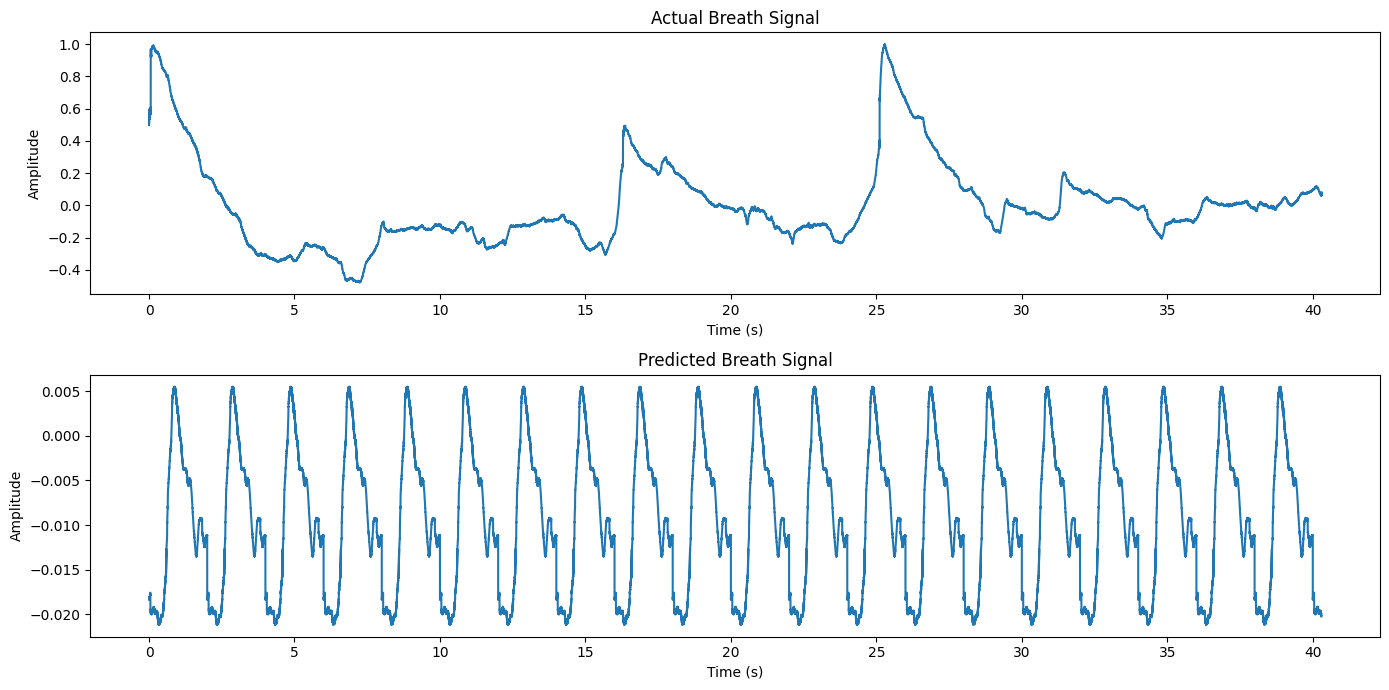

In [ ]:
import numpy as np
import librosa
import tensorflow as tf
import matplotlib.pyplot as plt

def preprocess_input(file_path, max_len_samples, sample_rate, segment_duration=2):
    # Load the speech signal
    y_speech, sr_speech = librosa.load(file_path, sr=sample_rate)

    # Pad the signal to max_len_samples
    y_speech_padded = np.pad(y_speech, (0, max_len_samples - len(y_speech)), 'constant')

    # Segment the padded signal
    speech_segments = []
    segment_length = segment_duration * sr_speech
    for start in range(0, len(y_speech_padded), segment_length):
        end = start + segment_length
        segment = y_speech_padded[start:end]
        if len(segment) == segment_length:  # Ensure segment is full-length
            speech_segments.append(segment)

    return np.array(speech_segments)

def predict_breath_signal(model, speech_file_path, max_len_samples, sample_rate):
    # Preprocess the input speech file
    speech_segments = preprocess_input(speech_file_path, max_len_samples, sample_rate)

    # Reshape segments for prediction (needed if the model expects input with shape (segment_length, 1))
    speech_segments = np.expand_dims(speech_segments, axis=-1)

    # Predict breath signal segments
    predicted_segments = model.predict(speech_segments)

    # Flatten the predicted segments back into a single continuous signal
    predicted_breath_signal = predicted_segments.flatten()

    # Truncate to the original signal length
    original_duration = librosa.get_duration(filename=speech_file_path)
    original_len_samples = int(original_duration * sample_rate)
    predicted_breath_signal = predicted_breath_signal[:original_len_samples]

    return predicted_breath_signal

def plot_signals(actual_breath_signal, predicted_breath_signal, sample_rate):
    plt.figure(figsize=(14, 7))

    # Plot actual breath signal
    plt.subplot(2, 1, 1)
    plt.plot(np.linspace(0, len(actual_breath_signal) / sample_rate, num=len(actual_breath_signal)), actual_breath_signal)
    plt.title('Actual Breath Signal')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')

    # Plot predicted breath signal
    plt.subplot(2, 1, 2)
    plt.plot(np.linspace(0, len(predicted_breath_signal) / sample_rate, num=len(predicted_breath_signal)), predicted_breath_signal)
    plt.title('Predicted Breath Signal')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')

    plt.tight_layout()
    plt.show()

# Example usage
speech_file_path = '/content/sample_data/Test/speaker48_channel1_trial1.wav'
breath_file_path = '/content/sample_data/Test/speaker48_channel3_trial1.wav'
max_len_samples = int(120.29945 * 20000)  # max_duration * sample_rate (from the training data)
sample_rate = 20000  # Ensure the sample rate matches the training data

# Load the saved model
model = tf.keras.models.load_model('my_conv1d_lstm_model.h5')

# Predict the breath signal
predicted_breath_signal = predict_breath_signal(model, speech_file_path, max_len_samples, sample_rate)

# Load the actual breath signal for comparison
actual_breath_signal, _ = librosa.load(breath_file_path, sr=sample_rate)

# Plot the actual and predicted breath signals
plot_signals(actual_breath_signal, predicted_breath_signal, sample_rate)


In [ ]:
import numpy as np
import librosa
import tensorflow as tf
import matplotlib.pyplot as plt

def predict_breath_signal(model, speech_file_path, sample_rate):
    # Load the speech signal using the full length of the file
    y_speech, sr_speech = librosa.load(speech_file_path, sr=sample_rate)

    # Reshape for prediction if the model expects a different input shape
    y_speech = np.expand_dims(y_speech, axis=-1)

    # Predict breath signal
    predicted_breath_signal = model.predict(np.expand_dims(y_speech, axis=0))

    # Flatten the predicted signal to 1D
    predicted_breath_signal = predicted_breath_signal.flatten()

    return predicted_breath_signal

def plot_signals(actual_breath_signal, predicted_breath_signal, sample_rate):
    plt.figure(figsize=(14, 7))

    # Plot actual breath signal
    plt.subplot(2, 1, 1)
    plt.plot(np.linspace(0, len(actual_breath_signal) / sample_rate, num=len(actual_breath_signal)), actual_breath_signal)
    plt.title('Actual Breath Signal')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')

    # Plot predicted breath signal
    plt.subplot(2, 1, 2)
    plt.plot(np.linspace(0, len(predicted_breath_signal) / sample_rate, num=len(predicted_breath_signal)), predicted_breath_signal)
    plt.title('Predicted Breath Signal')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')

    plt.tight_layout()
    plt.show()

# Example usage
speech_file_path = '/content/sample_data/Test/speaker48_channel1_trial1.wav'
breath_file_path = '/content/sample_data/Test/speaker48_channel3_trial1.wav'
sample_rate = 20000  # Ensure the sample rate matches the training data

# Load the saved model
model = tf.keras.models.load_model('my_conv1d_lstm_model.h5')

# Predict the breath signal
predicted_breath_signal = predict_breath_signal(model, speech_file_path, sample_rate)

# Load the actual breath signal for comparison
actual_breath_signal, _ = librosa.load(breath_file_path, sr=sample_rate)

# Plot the actual and predicted breath signals
plot_signals(actual_breath_signal, predicted_breath_signal, sample_rate)


ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense_1" is incompatible with the layer: expected axis -1 of input shape to have value 2500, but received input with shape (1, 50370)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(1, 805925, 1), dtype=float32)
  • training=False
  • mask=None